In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split

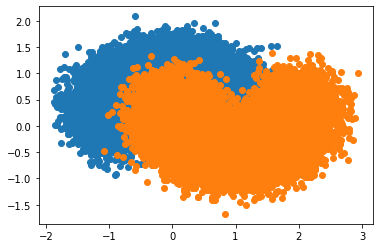

In [2]:
# make_moons是函数用来生成数据集
# x是特征，y是标签
x, y = datasets.make_moons(n_samples=50000, noise=0.3, random_state=42)
# print(x)
# print(y)
# 样本中标签为0的那些样本的第0列特征
# print(x[y == 0, 0])
plt.scatter(x[y == 0, 0], x[y == 0, 1])  # 特征中标签为0的第0列和第1列
plt.scatter(x[y == 1, 0], x[y == 1, 1])  # 特征中标签为1的第0列和第1列
plt.show()

In [5]:
# 默认分割比例是75%和25%
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

In [9]:
from sklearn.linear_model import LogisticRegression

log_clf = LogisticRegression()
log_clf.fit(x_train, y_train)
log_clf.score(x_test, y_test)

0.85336

In [10]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(x_train, y_train)
svm_clf.score(x_test, y_test)

0.91216

In [6]:
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier()
dt_clf.fit(x_train, y_train)
dt_clf.score(x_test, y_test)

0.87592

In [12]:
y_predict1 = log_clf.predict(x_test)
y_predict2 = svm_clf.predict(x_test)
y_predict3 = dt_clf.predict(x_test)

In [14]:
# 纯手动bagging
from sklearn.metrics import accuracy_score
y_predict = np.array((y_predict1 + y_predict2 + y_predict3) >= 2, dtype='int')
print(y_predict[:10])
print(y_test[:10])
# 计算准确率
accuracy_score(y_test, y_predict)

[1 1 1 0 0 0 0 0 0 1]
[1 1 1 0 0 0 0 1 0 1]


0.9044

# 集成学习

In [18]:
from sklearn.ensemble import VotingClassifier

# hard模式：少数服从多数
voting_clf = VotingClassifier(estimators=[
    ('log_clf', LogisticRegression()),
    ('svm_clf', SVC()),
    ('dt_clf', DecisionTreeClassifier())],voting='hard')
voting_clf.fit(x_train, y_train)
voting_clf.score(x_test, y_test)

0.90424

In [20]:
# 更合理的投票，应该有权值
voting_clf = VotingClassifier(estimators=[
    ('log_clf', LogisticRegression()),
    ('svm_clf', SVC(probability=True)),  # 支持向量机中需要加入probability
    ('dt_clf', DecisionTreeClassifier())],voting='soft')
voting_clf.fit(x_train, y_train)
voting_clf.score(x_test, y_test)

0.90456

# bagging

In [7]:
from sklearn.tree import DecisionTreeClassifier  # 用决策树集成上千模型
from sklearn.ensemble import BaggingClassifier

# bootstrap：是否为放回取样,default=True
bagging_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=300, max_samples=3000, bootstrap=True)
bagging_clf.fit(x_train, y_train)
bagging_clf.score(x_test, y_test)

0.91208

# oob设计

In [45]:
# oob_score：是否使用袋外样本估计泛化误差,default=False
bagging_clf2 = BaggingClassifier(DecisionTreeClassifier(),
                                 n_estimators=500,
                                 max_samples=100,
                                 bootstrap=True,
                                 oob_score=True)
bagging_clf2.fit(x_train, y_train)
# 拿没有取到的数据集作为测试集
bagging_clf2.oob_score_

0.9119466666666667

In [24]:
bagging_clf2.score(x_test, y_test)

0.90936

# n_jobs

In [48]:
%%time
# cpu time是实际cpu运行算法时间，wall time是墙上真实时间，就是real time（包含了进程启动时间，I/O等待时间等）
bagging_clf = BaggingClassifier(DecisionTreeClassifier(),
                                n_estimators=500,
                                max_samples=2000,
                                bootstrap=True)
bagging_clf.fit(x_train, y_train)
bagging_clf.score(x_test, y_test)

CPU times: total: 3.34 s
Wall time: 3.33 s


0.91184

In [26]:
%%time
# 多核使用的时间更小
bagging_clf = BaggingClassifier(DecisionTreeClassifier(),
                                n_estimators=500, max_samples=2000,
                                bootstrap=True, n_jobs=-1)
bagging_clf.fit(x_train, y_train)
bagging_clf.score(x_test, y_test)

CPU times: total: 312 ms
Wall time: 2.41 s


0.91304

# bootstrap_features

In [30]:
# bootstrap_features: 是否针对特征随机取样
# max_features: 从X中提取的用于训练每个基本估计器的特征数
# 因为我们就两个特征，所以max_features设置为1;得到的分值较低是因为我们特征较少，采用随机特征不合适
random_subspaces_clf = BaggingClassifier(DecisionTreeClassifier(),
                                         n_estimators=500,
                                         max_samples=500,
                                         oob_score=True,
                                         n_jobs=-1,
                                         max_features=1,
                                         bootstrap_features=True)
random_subspaces_clf.fit(x,y)
random_subspaces_clf.oob_score_

0.88426

In [8]:
# 验证总的抽样的样本数不能大于训练集的数目
random_patches_clf = BaggingClassifier(DecisionTreeClassifier(),
                                       n_estimators=500,
                                       max_samples=50001,
                                       oob_score=True,
                                       bootstrap=True,
                                       n_jobs=-1,
                                       max_features=1,
                                       bootstrap_features=True)
random_patches_clf.fit(x, y)
random_patches_clf.oob_score_

ValueError: max_samples must be in (0, n_samples]

In [33]:
from sklearn.ensemble import RandomForestClassifier

In [34]:
%%time
# random_state：控制原始数据集的随机重采样（采样和特征）。如果基估计器接受随机状态属性，则为集合中的每个实例生成不同的种子。
rc_clf = RandomForestClassifier(n_estimators=500,
                                random_state=666,
                                oob_score=True,
                                n_jobs=-1)
rc_clf.fit(x, y)
rc_clf.oob_score_

CPU times: total: 37.2 s
Wall time: 5.13 s


0.90322

In [35]:
%%time
# max_leaf_nodes: 最大的叶子结点数
rc_clf2 = RandomForestClassifier(n_estimators=500,
                                 max_leaf_nodes=16,
                                 random_state=666,
                                 oob_score=True,
                                 n_jobs=-1)
rc_clf2.fit(x, y)
rc_clf2.oob_score_

CPU times: total: 20.6 s
Wall time: 3.45 s


0.90962

# Extra-Trees

In [36]:
from sklearn.ensemble import ExtraTreesClassifier

et_clf = ExtraTreesClassifier(n_estimators=500,
                              oob_score=True,
                              bootstrap=True,  # 放回取样
                              n_jobs=-1)
et_clf.fit(x, y)
et_clf.oob_score_

0.90626

# Boosting

In [38]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [43]:
%%time
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(), n_estimators=500)
ada_clf.fit(x_train, y_train)
ada_clf.score(x_test, y_test)

CPU times: total: 93.8 ms
Wall time: 104 ms


0.876

In [37]:
# 默认用的也是决策树，增加了基分类器的数目后，准确率提升
from sklearn.ensemble import GradientBoostingClassifier

gb_clf = GradientBoostingClassifier(max_depth=2, n_estimators=500)
gb_clf.fit(x_train, y_train)
gb_clf.score(x_test, y_test)

0.91144